In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

In [2]:
import sys
sys.path.append("../code/")

In [3]:
from nomenclature import metastatic_site_unification_dict
from nomenclature import cancer_unification_dict

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import seaborn as sns

In [6]:
import matplotlib as mpl

mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

### Preprocess metastasis frequency data from autopsy studies
The data has been extracted by hand from five publications into excel files, stored in `data/metastasis_frequency_data/`

In [7]:
DATA_ROOT = Path("../data/metastasis_frequency_data/")

Load the data and do some basic formatting

In [8]:
df = pd.concat([
    pd.read_excel(byhand_excel_file)
    for byhand_excel_file in DATA_ROOT.glob("*/*byhand*.xlsx")
    if str(byhand_excel_file).find("~") == -1
], ignore_index=True)
df.columns = [x.replace(" ", "_") for x in df.columns]
df["cancer"] = df.cancer.apply(lambda x: x.replace("_cancer", ""))

Unifiy the nomenclature of organs and metastatic target sites across publications

In [9]:
df["cancer"] = df.cancer.apply(lambda x: cancer_unification_dict[x])
df["metastatic_site"] = df.metastatic_site.apply(lambda x: metastatic_site_unification_dict[x])

Store some useful fields and save as pickle

In [10]:
df["_pair"] = df.cancer + " -> " + df.metastatic_site
_pair_num_of_studies = df["_pair"].value_counts()
df["_num_studies"] = df._pair.apply(lambda x: _pair_num_of_studies.loc[x])
df["Study"] = df.study + ", " + df.year.astype(str)

df.to_pickle("../output/data/experimental_metastasis_freqs/all-experimental-metastais-frequency-data.p")

### Autopsy data figures

In [11]:
pd.to_pickle(
    dict(zip(df.Study.unique(),sns.xkcd_palette(["windows blue", "amber", "greyish", "faded green", "dusty purple"]))),
    ("../output/data/experimental_metastasis_freqs/study-colors-dict.p")
)

In [12]:
marker_dict = dict(zip(df.Study.unique(), ["s", "o", "v", "^", "d"]))
hue_order = [x for x in df.Study.unique()]

In [13]:
def do_meta_comparison_figure(df, cancer_type):
    sdf = df.loc[
        (df.cancer == cancer_type) & 
        (df._num_studies >= 2 )
    ].sort_values(by="metastatic_site")
    _hue_order = [x for x in hue_order if x in sdf.Study.unique()]
    oversampled_sdf = []
    for x in sdf.index:
        xx = sdf.loc[x].copy()
        p = xx.fraction_of_patients_with_metastasis
        N = int(xx.patients_with_some_metastasis)
        nyes = int(round(N *p))
        nno = N - nyes
        xxx = pd.DataFrame([xx] * N).copy()
        xxx.fraction_of_patients_with_metastasis = [1] * nyes + [0] * nno
        oversampled_sdf.append(xxx)
    oversampled_sdf = pd.concat(oversampled_sdf)

    n_sites = len(sdf.metastatic_site.unique())

    fig, ax = plt.subplots(1, 1, figsize=(5.3, n_sites * 0.55), tight_layout=True)
    sns.pointplot(
        data=oversampled_sdf,
        x="fraction_of_patients_with_metastasis",
        y="metastatic_site",
        hue="Study",
        dodge=0.4,
        markers = [marker_dict[t] for t in _hue_order],
        hue_order = _hue_order,
        palette = dict(zip(df.Study.unique(),sns.xkcd_palette(["windows blue", "amber", "greyish", "faded green", "dusty purple"]))),
        markersize=1,
        errwidth = 2,
        capsize=0.2,
        scale=0.85,
        join=False
    )
    ax.legend(loc='upper right', bbox_to_anchor=(0, 0), frameon=False)
    ax.set_title((cancer_type[0].upper() + cancer_type[1:] + " cancer").replace("Pancreas", "Pancreatic"))
    ax.grid(ls="dotted", which="both")
    ax.set_xlabel("Fraction of patients")
    ax.set_ylabel("Metastatic site")
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_xticks(np.arange(0, 1, 0.1), minor=True)
    
    fig.savefig(f"../figures/autopsy-data-meta-analysis/{cancer_type.replace(' ', '-')}-cancer-meta-analysis.png", dpi=150)
    return fig, ax


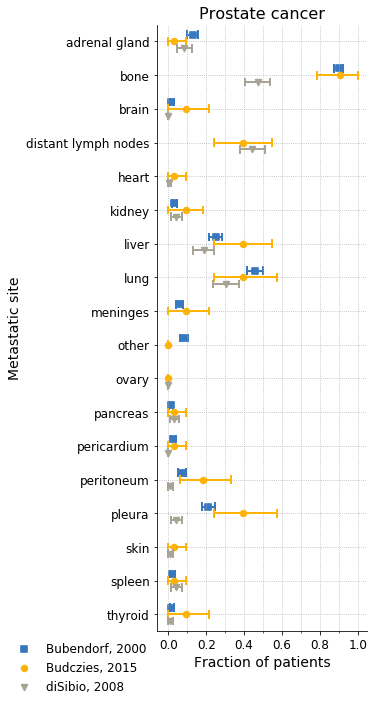

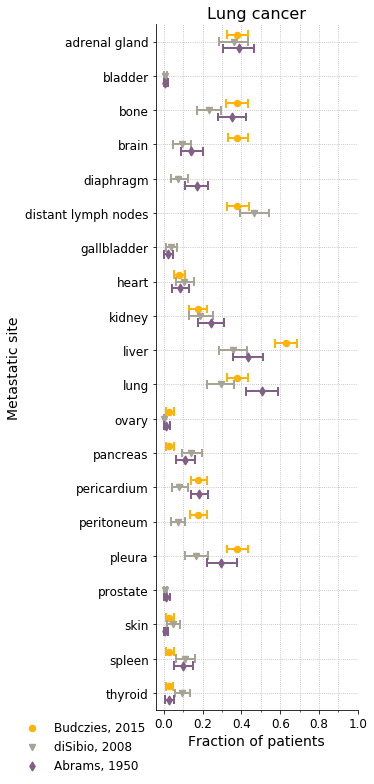

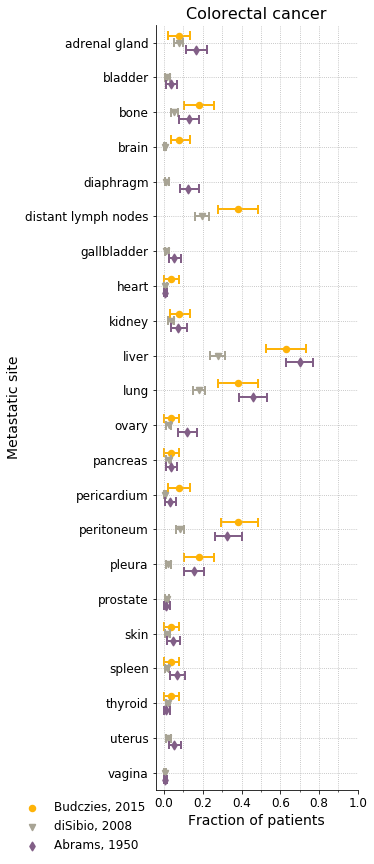

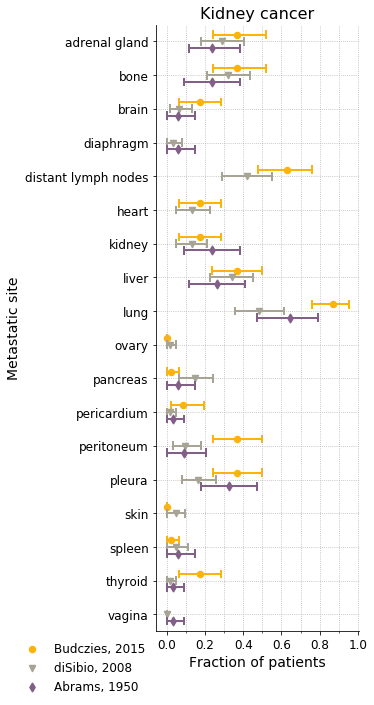

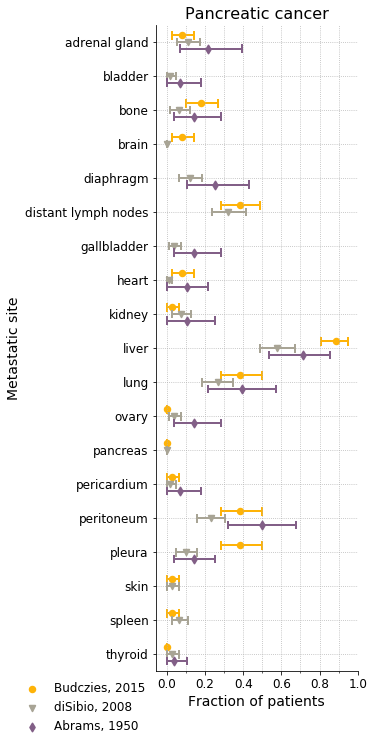

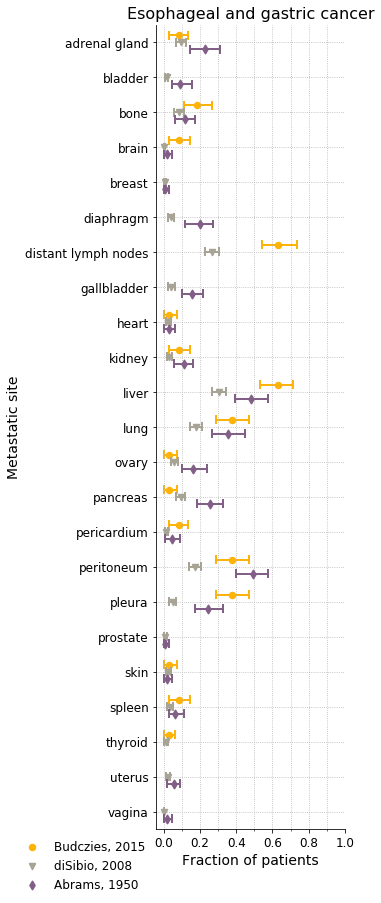

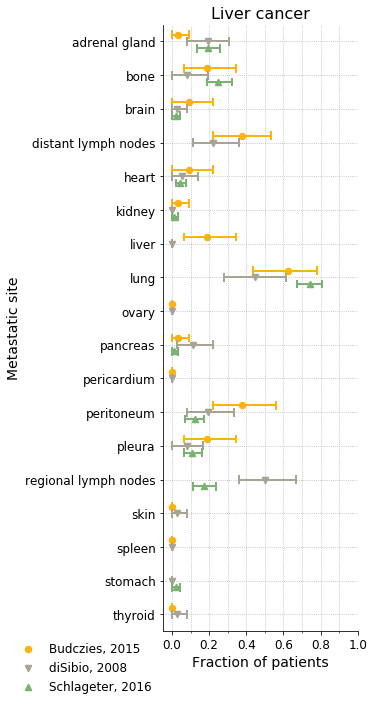

In [14]:
for cancer_type in ["prostate", "lung", "colorectal", "kidney", "pancreas", "esophageal and gastric", "liver"]:
    fig, ax = do_meta_comparison_figure(df, cancer_type)
